## Loading Required Libraries

In [1]:
import os
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

In [2]:
# Define the format
reader = Reader(line_format='user item rating timestamp', sep='\t')
ratings = pd.read_csv('data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.shape

(100836, 3)

No NA's

In [4]:
reader = Reader(rating_scale=(0.5, 5.0))


data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# Split data into 5 folds

data.split(n_folds=5)

## EDA

### Ratings Distribution

In [7]:

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Ratings Distribution By Item

In [8]:
data = df.groupby('itemID')['rating'].count().clip(upper=50)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Item (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Item'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [9]:
df.groupby('itemID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,itemID,rating
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
224,260,251
418,480,238
97,110,237
507,589,224
461,527,220


### Ratings Distribution By User

In [10]:
data = df.groupby('userID')['rating'].count().clip(upper=80)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [11]:
df.groupby('userID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userID,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
609,610,1302
67,68,1260
379,380,1218
605,606,1115
287,288,1055


The minimumn number of ratings given by a user is 20, where as the most productive user is user-414 giving 2798 rating.
The data is properly distributed and the big chunk of ratings is between 3 and 5 which means people are not very hard towards rating

## Surprise
To load a dataset from a pandas dataframe, we will use the __load_from_df()__ method.

we will also need a Reader object, and the rating_scale parameter which is specified above. 
<font color=red> We will use __RMSE__ as our accuracy metric for the predictions. </font>

In [5]:
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

                     
                                        

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [6]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.880474,11.617381,0.909387
NMF,0.932549,14.859058,0.756625
KNNBasic,0.959394,0.305961,5.957084
NormalPredictor,1.427667,0.273312,0.694861


#### Tunining algorithm parameters with GridSearchCV

#Default values for svd( ):

<b> n_factors </b> - 100 <br>
<b>n_epochs </b> - 20 <br>
<b>lr_all </b> – 0.005 <br>
<b>reg_all </b> – 0.02 <br>

In [12]:
param_grid = {'n_factors': [15, 20, 25, 30], 'n_epochs': [2, 10, 15, 20], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8708986439318185
{'n_factors': 30, 'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.08}


##### The best_estimator attribute gives us an algorithm instance with the optimal set of parameters, which can be used to fit the model

In [17]:
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

{'test_rmse': array([0.88364384, 0.87805683, 0.88194174]),
 'fit_time': (2.7478058338165283, 2.9364421367645264, 2.7119228839874268),
 'test_time': (0.33649277687072754, 0.3202250003814697, 0.3826911449432373)}

We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. <br>
We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [7]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=30, n_epochs=20, lr_all=0.008, reg_all=0.08)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8675


0.8674752308838913

In [43]:
def get_Iu(uid):
    """ 
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ 
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [44]:
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,414,2369,2.0,2.821613,{'was_impossible': False},2044,16,0.821613
1,409,1244,3.0,4.302388,{'was_impossible': False},96,23,1.302388
2,590,8665,3.0,3.615785,{'was_impossible': False},558,60,0.615785
3,509,63992,1.5,2.020366,{'was_impossible': False},360,16,0.520366
4,68,63113,3.0,3.267534,{'was_impossible': False},949,26,0.267534


In [46]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [47]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
23757,122,778,5.0,5.0,{'was_impossible': False},218,81,0.0
13680,43,457,5.0,5.0,{'was_impossible': False},86,146,0.0
12791,348,296,5.0,5.0,{'was_impossible': False},45,224,0.0
8823,171,720,5.0,5.0,{'was_impossible': False},61,25,0.0
12440,171,1208,5.0,5.0,{'was_impossible': False},61,74,0.0
11463,1,2329,5.0,5.0,{'was_impossible': False},170,91,0.0
7945,25,527,5.0,5.0,{'was_impossible': False},18,168,0.0
15243,452,527,5.0,5.0,{'was_impossible': False},153,168,0.0
737,452,1617,5.0,5.0,{'was_impossible': False},153,71,0.0
9127,52,318,5.0,5.0,{'was_impossible': False},100,228,0.0


In [48]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
13566,129,1358,0.5,4.278384,{'was_impossible': False},101,36,3.778384
12166,543,5481,0.5,4.278493,{'was_impossible': False},57,50,3.778493
23625,598,593,0.5,4.294867,{'was_impossible': False},13,207,3.794867
24669,495,5952,0.5,4.337627,{'was_impossible': False},193,147,3.837627
14624,573,44199,0.5,4.352674,{'was_impossible': False},236,29,3.852674
15249,580,1250,0.5,4.373383,{'was_impossible': False},347,30,3.873383
21655,573,8376,0.5,4.427224,{'was_impossible': False},236,27,3.927224
17054,105,4027,0.5,4.495972,{'was_impossible': False},557,74,3.995972
4781,256,5618,0.5,4.677661,{'was_impossible': False},131,63,4.177661
19986,543,89904,0.5,4.883319,{'was_impossible': False},57,7,4.383319


The worst predictions look pretty surprise. Let's look in more details of item "89904",  rated 0.5, our SVD algorithm predicts 4.8.

In [64]:
df.loc[df['itemID'] == 89904]['rating'].describe()

count    11.000000
mean      4.045455
std       1.386624
min       0.500000
25%       4.000000
50%       4.500000
75%       5.000000
max       5.000000
Name: rating, dtype: float64

<IPython.core.display.Javascript object>


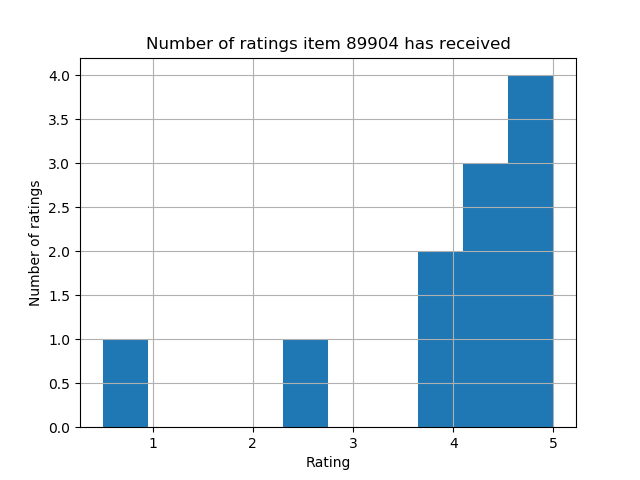

In [68]:
import matplotlib.pyplot as plt
%matplotlib notebook

df.loc[df['itemID'] == 89904]['rating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings item 89904 has received')
plt.show();

It turns out, most of the ratings this Item received between "3.5 and 5",only very few users rated "0". Same with the other predictions in "worst predictions" list. It seems that for each prediction, the users are some kind of outsiders.

#### Have to decide N for Top N Recommendations

In [45]:
df_predictions.head(5)

,uid,iid,rui,est,details,Iu,Ui,err
0,414,2369,2.0,2.821613,{'was_impossible': False},2044,16,0.821613
1,409,1244,3.0,4.302388,{'was_impossible': False},96,23,1.302388
2,590,8665,3.0,3.615785,{'was_impossible': False},558,60,0.615785
3,509,63992,1.5,2.020366,{'was_impossible': False},360,16,0.520366
4,68,63113,3.0,3.267534,{'was_impossible': False},949,26,0.267534


In [46]:
df_predictions.sort_values(['uid','err'],ascending = [True,True], inplace = True)
df_predictions.head(5)

,uid,iid,rui,est,details,Iu,Ui,err
7191,1,2046,4.0,4.020556,{'was_impossible': False},178,16,0.020556
2417,1,2492,4.0,3.951950,{'was_impossible': False},178,5,0.048050
3605,1,50,5.0,4.938407,{'was_impossible': False},178,154,0.061593
23717,1,1552,4.0,3.880084,{'was_impossible': False},178,43,0.119916
16269,1,1197,5.0,4.855637,{'was_impossible': False},178,105,0.144363


In [47]:
top_n = 10 #Top 10 values
rank_df = df_predictions.groupby('uid').head(top_n)
rank_df.head(12)

,uid,iid,rui,est,details,Iu,Ui,err
7191,1,2046,4.0,4.020556,{'was_impossible': False},178,16,0.020556
2417,1,2492,4.0,3.951950,{'was_impossible': False},178,5,0.048050
3605,1,50,5.0,4.938407,{'was_impossible': False},178,154,0.061593
23717,1,1552,4.0,3.880084,{'was_impossible': False},178,43,0.119916
16269,1,1197,5.0,4.855637,{'was_impossible': False},178,105,0.144363
16395,1,2985,4.0,4.178590,{'was_impossible': False},178,52,0.178590
13149,1,2571,5.0,4.795021,{'was_impossible': False},178,215,0.204979
1978,1,2099,4.0,4.212681,{'was_impossible': False},178,5,0.212681
10186,1,2858,5.0,4.783751,{'was_impossible': False},178,155,0.216249
20291,1,923,5.0,4.774729,{'was_impossible': False},178,50,0.225271


In [48]:
rank_df['rank'] = rank_df.groupby('uid')['err'].rank(ascending=True, method='min')
rank_df.head(12)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,uid,iid,rui,est,details,Iu,Ui,err,rank
7191,1,2046,4.0,4.020556,{'was_impossible': False},178,16,0.020556,1.0
2417,1,2492,4.0,3.951950,{'was_impossible': False},178,5,0.048050,2.0
3605,1,50,5.0,4.938407,{'was_impossible': False},178,154,0.061593,3.0
23717,1,1552,4.0,3.880084,{'was_impossible': False},178,43,0.119916,4.0
16269,1,1197,5.0,4.855637,{'was_impossible': False},178,105,0.144363,5.0
16395,1,2985,4.0,4.178590,{'was_impossible': False},178,52,0.178590,6.0
13149,1,2571,5.0,4.795021,{'was_impossible': False},178,215,0.204979,7.0
1978,1,2099,4.0,4.212681,{'was_impossible': False},178,5,0.212681,8.0
10186,1,2858,5.0,4.783751,{'was_impossible': False},178,155,0.216249,9.0
20291,1,923,5.0,4.774729,{'was_impossible': False},178,50,0.225271,10.0


In [49]:
print('MEAN err:')
print(rank_df.groupby('rank').agg({'err':'mean'}))

MEAN err:
           err
rank          
1.0   0.084998
2.0   0.168374
3.0   0.252328
4.0   0.334411
5.0   0.402259
6.0   0.457767
7.0   0.445033
8.0   0.479149
9.0   0.516149
10.0  0.502975


#### Let's predict ratings for the movies which user has not yet watched and build recommendations for the user.

In [50]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n


In [51]:
#data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=30, n_epochs=20, lr_all=0.008, reg_all=0.08)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

'''Return a list of ratings that can be used as a testset in the test() method.
The ratings are all the ratings that are not in the trainset, i.e. all the ratings rui where the user u is known, 
the item i is known, but the rating rui is not in the trainset. As rui is unknown, it is either replaced by the fill value
 or assumed to be equal to the mean of all ratings global_mean.'''

predictions = algo.test(testset)

#To get all predictions
all_pred = get_all_predictions(predictions)



In [52]:
#To get top 7 reommendation
#As decided above, we will recommend 7 movies
n = 7

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]


In [53]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [54]:
tmp = pd.DataFrame.from_dict(all_pred)
#tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp_transpose = tmp.transpose()


In [55]:
user_id=17
results = get_predictions(user_id)
results

0       (1104, 4.58257979716958)
1      (3451, 4.570110138925656)
2    (177593, 4.556970847787843)
3       (898, 4.525146707161053)
4      (1204, 4.521744833483486)
5      (1217, 4.509606787051535)
6       (951, 4.504528481667162)
Name: 17, dtype: object

In [56]:
recommended_movie_ids=[]
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids


[1104, 3451, 177593, 898, 1204, 1217, 951]

In [57]:
movies = pd.read_csv('data/movies.csv')
movies.head()
df = movies[movies['movieId'].isin(recommended_movie_ids)]
df

,movieId,title,genres
680,898,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
731,951,His Girl Friday (1940),Comedy|Romance
841,1104,"Streetcar Named Desire, A (1951)",Drama
906,1204,Lawrence of Arabia (1962),Adventure|Drama|War
918,1217,Ran (1985),Drama|War
2582,3451,Guess Who's Coming to Dinner (1967),Drama
9618,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama


In [58]:
#Create the dictionary that defines the order for sorting
recommended_movie_ids_Index = dict(zip(recommended_movie_ids,range(len(recommended_movie_ids))))

# Generate a rank column that will be used to sort the dataframe numerically
df['movieId_Rank'] = df['movieId'].map(recommended_movie_ids_Index)

#sort the df using th new column created
df.sort_values(['movieId_Rank'],ascending = [True], inplace = True)

#drop the rank column
df.drop('movieId_Rank', 1, inplace = True)

df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,movieId,title,genres
841,1104,"Streetcar Named Desire, A (1951)",Drama
2582,3451,Guess Who's Coming to Dinner (1967),Drama
9618,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
680,898,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
906,1204,Lawrence of Arabia (1962),Adventure|Drama|War
918,1217,Ran (1985),Drama|War
731,951,His Girl Friday (1940),Comedy|Romance


### Voila, It's done!!

In [ ]:
tmp_transpose.head(5)

In [11]:
from functools import reduce
mean=[]
#def Average(lst): 
    #return sum(lst) / len(lst) 
#    return reduce(lambda a, b: a + b, lst) / len(lst) 

for x in range(0,n):
    a = pd.DataFrame(tmp_transpose[x])
    list=[]
    for x in range(0, len(a)):
        b = a.iloc[x]
        value = float(str(b).split()[2].split(')')[0])
        list.append(value)
    list = pd.DataFrame(list)
    list = list/5.0
    avg = list[0].mean()
    mean.append(avg)

mean

[0.8854584515030504,
 0.8795829851829073,
 0.8760441415477946,
 0.8734800588476651,
 0.871233290967018,
 0.8692340754503163,
 0.8673931362589001,
 0.8657112331750442,
 0.8641941533962301,
 0.8627670170733033,
 0.8614514130476504,
 0.8602722919512875,
 0.8592089367606623,
 0.8582498011864561,
 0.857259493703421,
 0.8563587688670349,
 0.8555476939501218,
 0.8547749549401003,
 0.8540744370766035,
 0.8533798234815446,
 0.8527537062843249,
 0.8521347223035178,
 0.8515799115258534,
 0.8510462278334271,
 0.8505393849803612,
 0.8500130731365348,
 0.8494926404959235,
 0.8490419247586429,
 0.8485748687116847,
 0.8481250061076191,
 0.8477100178304735,
 0.847291233707815,
 0.8468739112015915,
 0.8464893004856612,
 0.8461126682323169,
 0.8457355602410552,
 0.8453363676749779,
 0.8449487085148241,
 0.8445756842850105,
 0.8442195038277258,
 0.8438774788552708,
 0.8435165135758382,
 0.843181561119464,
 0.8428598420457017,
 0.8425473906499057,
 0.8422377765192269,
 0.8419235519092648,
 0.84161412230407